# The predicted annihilation signal from prompt cusps
This notebook is all about "Section 5: Results" from the paper.
For this we
* create a large number of orbits in the Milky Way
* sample a large number of cusps (for a 100 GeV WIMP)
* apply the reduction in annihilation luminosity due to smooth tides + encounters

Then we use this to predict
* the spatial reduction in the annihilation signal due to encounters
* the spatial dependence of the annihilation signal
* the angular dependence of the annihilation signal -- in comparison to the GCE
* the contributions of prompt cusps to the IGRB

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../adiabatic-tides")
sys.path.append("..")

import adiabatic_tides as at
import cusp_encounters.milkyway
import cusp_encounters.encounters_math as em
import cusp_encounters.cusp_distribution
from cusp_encounters.decorators import h5cache
import scipy.integrate
import cusp_encounters.gammaray as gammaray

%load_ext autoreload
cachedir = "../caches"

G = 43.0071057317063e-10 # Mpc (km/s)^2 / Msol 

# Calculations
## orbits

In [2]:
mw = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir, mode="cautun_2020")
orbits_full = mw.create_dm_orbits(100000, nsteps=100000, rmax=500e3, addinfo=True, adaptive=True, subsamp=100)

reading


In [3]:
subsamp = 1 # put e.g. 100 here if you want to execute the rest of the notebook more quickly, but at lower statistics
orbits = {} # Sample down a bit more to keep things quick
for key in "chi_star", "pos", "chi_dm":
    orbits[key] = orbits_full[key][::subsamp]
orbits["mass"] = orbits_full["mass"]

## cusps

In [4]:
%%time
cuspdis = cusp_encounters.cusp_distribution.CuspDistribution(cachedir=cachedir)
cusps = cuspdis.sample_cusps(10000000)

Warning, I have to insert the correct WIMP fmax for m!=100mev here
Inferred v0=2.769e-08, fmax=9.909e+31 using mx=100GeV, Tkd=30MeV, ad=5.33e-12
CPU times: user 14.3 s, sys: 2.13 s, total: 16.4 s
Wall time: 16.5 s


In [5]:
# Since we might not exactly have the same number of orbit-sampling points as cusps,
# we deform / repeat our cusp distribution to achieve the same shape
shape = orbits["chi_star"].shape
nrepeats = int(np.ceil(np.prod(shape) / cusps["A"].shape[0]))
def deform(arr):
    return np.repeat(arr, nrepeats)[:np.prod(shape)].reshape(shape)

As, rcusps, rcores  = deform(cusps["A"]), deform(cusps["rcusp"]), deform(cusps["rcore"])

Bcusps, Bcores = em.Bresistance_of_r(rcusps, A=As), em.Bresistance_of_r(rcores, A=As)

mdm_per_samp = cusps["mdm_per_cusp"]

## reduced annihilation signal

In [6]:
r = np.linalg.norm(orbits["pos"], axis=-1)
chistar = orbits["chi_star"][-1] * np.ones_like(orbits["chi_star"])
rperi = np.min(r, axis=0)

Bstar = 2.*np.pi*np.clip(chistar, 1e-10, None)*mw.G
Beff= em.sample_effective_B_hist(shape, Bminfac=1e-4, p=1.2, initial_sample=100000, cachefile="%s/Beff_hist.hdf5" % cachedir) * Bstar
Beff_tide = np.sqrt(np.clip(42.2*mw.radial_mean_tide(rperi), 1e-10, None))*np.ones(r.shape)
Beff_tot= np.sqrt(Beff**2 + Beff_tide**2)

Js = em.Jcorecusp_in_4piA2(Beff, Bcores, Bcusps) * 4.*np.pi*As**2
Jstot = em.Jcorecusp_in_4piA2(Beff_tot, Bcores, Bcusps) * 4.*np.pi*As**2
Jstide = em.Jcorecusp_in_4piA2(Beff_tide, Bcores, Bcusps) * 4.*np.pi*As**2

J0s = em.Jcorecusp_in_4piA2(Bcusps*1e-7, Bcores, Bcusps) * 4.*np.pi*As**2

Bmax = em.sample_strongest_B_analytic(Bstar)
Jsmax = em.Jcorecusp_in_4piA2(Bmax, Bcores, Bcusps) * 4.*np.pi*As**2

## Histograms etc.

In [7]:
%%time
rbins = np.logspace(-1,np.log10(1e3), 81)
mi = orbits["mass"]*np.ones(r.shape)
ri, perc = em.get_percentile_profile(r/1000., Js/J0s, xbins=rbins, weights=mi)
ri, perctot = em.get_percentile_profile(r/1000., Jstot/J0s, xbins=rbins, weights=mi)
# Each of these represents the total annihilation coming from inside each spherical shell
nxJ, _ = np.histogram(r/1000., weights=Js*mi/mdm_per_samp / len(r), bins=rbins)
nxJtot, _ = np.histogram(r/1000., weights=Jstot*mi/mdm_per_samp / len(r), bins=rbins)
nxJtide, _ = np.histogram(r/1000., weights=Jstide*mi/mdm_per_samp / len(r), bins=rbins)
nxJmax, _ = np.histogram(r/1000., weights=Jsmax*mi/mdm_per_samp / len(r), bins=rbins)
nxJ0s, _ = np.histogram(r/1000., weights=J0s*mi/mdm_per_samp / len(r), bins=rbins)
n, _ = np.histogram(r/1000., bins=rbins, weights=mi /len(r))
vbins = 4.*np.pi/3. * (rbins[1:]**3 - rbins[:-1]**3)

ri, percmax = em.get_percentile_profile(r/1000., Jsmax/J0s, xbins=rbins, weights=mi)

CPU times: user 3min 52s, sys: 48.3 s, total: 4min 40s
Wall time: 4min 41s


# Results
## annihilation reduction

No handles with labels found to put in legend.


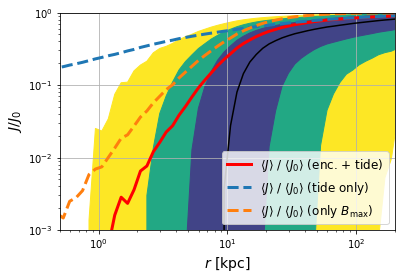

In [8]:
#em.percentile_plot(ri, perc, ylabel=r"$J / J_0$", loc="upper left")
em.percentile_plot(ri, perctot, ylabel=r"$J / J_0$", loc="upper left", labels=[None, None, None, None])

plt.loglog(ri, nxJtot/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (enc. + tide)", color="red", lw=3)
#plt.loglog(ri, nxJ/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (enc. only)", color="C1", lw=3, linestyle="dashed")
plt.loglog(ri, nxJtide/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (tide only)", color="C0", lw=3, linestyle="dashed")
plt.loglog(ri, nxJmax/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (only $B_{\rm{max}}$)", color="C1", lw=3, linestyle="dashed")

plt.ylim(1e-3, 1e0)
plt.legend([])
plt.legend(fontsize=12, loc="lower right")

plt.savefig("img/radial_J_over_J0.pdf", bbox_inches="tight")

#plt.loglog(ri, nxJtot/nxJ0s, label=r"$\langle J \rangle$ / $\langle J_0 \rangle$ (+ cusp enc.)", color="orange", lw=3, linestyle="dotted")

## spatial profile of the signal

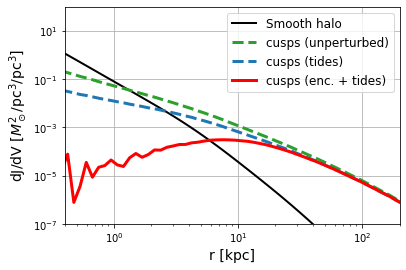

In [9]:
plt.loglog(ri, (mw.profile_contracted_nfw.self_density(ri/1e3)*1e-18)**2, label="Smooth halo", color="black", lw=2)
plt.loglog(ri, nxJ0s/(vbins*1e9), label="cusps (unperturbed)", lw=3, color="C2", linestyle="dashed")
plt.loglog(ri, nxJtide/(vbins*1e9), label="cusps (tides)", lw=3, color="C0", linestyle="dashed")
plt.loglog(ri, nxJtot/(vbins*1e9), label="cusps (enc. + tides)", lw=3, color="red")
#plt.loglog(ri, nxJmax/(vbins*1e9), label="[only strongest encounter]", lw=2, linestyle="dashed", color="C2")

#plt.loglog(ri, mw.profile_contracted_nfw.self_density(ri/1e3) * 1e-9)

plt.legend(fontsize=12)
plt.xlim(0.4,2e2)
plt.grid()
plt.xlabel("r [kpc]", fontsize=14)
plt.ylabel(r"$\rm{d} J/\rm{d} V$ [$M_\odot^2 / \rm{pc}^3 / \rm{pc}^3$]", fontsize=14)

plt.ylim(1e-7,1e2)

plt.savefig("img/radial_annihilation_profile.pdf", bbox_inches="tight")

## Angular profiles

In [10]:
%%time
# This takes very long ~ 1 hour, so I cache it. Make sure to reset the cache if you modify any of the involved variables
@h5cache(file="%s/angle_histogram.hdf5" % cachedir)
def angle_histograms(nsel=1000, d=8200., nalpha=100):
    alpha, Jalpha0 = em.angle_histogram(r[0:nsel].flatten(), (J0s*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=nalpha, d=d)
    alpha, Jalpha = em.angle_histogram(r[0:nsel].flatten(), (Js*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=nalpha, d=d)
    alpha, Jalphatot = em.angle_histogram(r[0:nsel].flatten(), (Jstot*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=nalpha, d=d)
    alpha, Jalphatide = em.angle_histogram(r[0:nsel].flatten(), (Jstide*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=nalpha, d=d)
    alpha, Jalphamax = em.angle_histogram(r[0:nsel].flatten(), (Jsmax*mi/mdm_per_samp/nsel)[0:nsel].flatten(), nalpha=nalpha, d=d)

    rhalo = np.logspace(-2, 4, 100000)
    rcent = np.sqrt(rhalo[1:]*rhalo[:-1])
    Jshalo = (mw.profile_contracted_nfw.self_density(rcent*1e-3)*1e-18)**2 *4.*np.pi/3. * ((1e3*rhalo[1:])**3 - (1e3*rhalo[:-1])**3)
    alpha, Jtothalo = em.angle_histogram(rcent*1e3, Jshalo, nalpha=nalpha, d=d)
    
    return alpha, Jalpha0, Jalpha, Jalphatot, Jalphatide, Jalphamax, Jtothalo

alpha, Jalpha0, Jalpha, Jalphatot, Jalphatide, Jalphamax, Jtothalo = angle_histograms(nsel=1000)

CPU times: user 3.65 ms, sys: 1.99 ms, total: 5.63 ms
Wall time: 6.56 ms


In [11]:
def sky_average(alpha, Jalpha, alphamin=0., alphamax=np.infty):
    sel = (alpha <= alphamax) & (alpha >= alphamin)
    Jtot = 2.*np.pi*scipy.integrate.simps((Jalpha*np.sin(alpha))[sel], alpha[sel])
    Omega = 2.*np.pi*scipy.integrate.simps((np.sin(alpha))[sel], alpha[sel]) # = 4 pi
    return Jtot/Omega

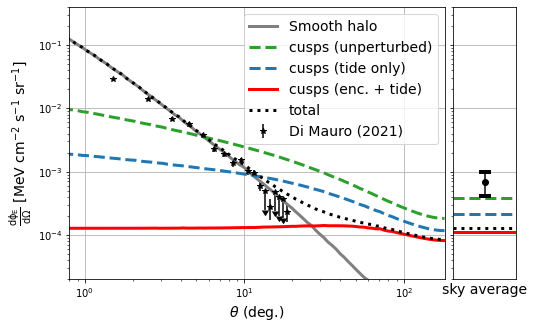

In [12]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8,5))
fig.subplots_adjust(wspace=0.04)

gs = GridSpec(1, 2, width_ratios=[6, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

nfac = gammaray.intragalactic_integral(1.) # 1.444e-05

ax1.loglog(alpha*180/np.pi, Jtothalo*nfac, label="Smooth halo", color="grey", lw=3)
#ax2.axhline(sky_average(alpha, Jtothalo*nfac), color="grey", lw=3)
ax1.loglog(alpha*180/np.pi, Jalpha0*nfac, label="cusps (unperturbed)", lw=3, color="C2", linestyle="dashed")
ax2.axhline(sky_average(alpha, Jalpha0*nfac, alphamin=20.*np.pi/180.),  lw=3, color="C2", linestyle="dashed")
ax1.loglog(alpha*180/np.pi, Jalphatide*nfac, label=r"cusps (tide only)", color="C0", linestyle="dashed", lw=3)
ax2.axhline(sky_average(alpha, Jalphatide*nfac, alphamin=20.*np.pi/180.), color="C0", linestyle="dashed", lw=3)
ax1.loglog(alpha*180/np.pi, Jalphatot*nfac, label="cusps (enc. + tide)", lw=3, color="red")
ax2.axhline(sky_average(alpha, Jalphatot*nfac, alphamin=20.*np.pi/180.),  lw=3, color="red")
ax1.loglog(alpha*180/np.pi, (Jalphatot+Jtothalo)*nfac, label="total", lw=3, color="black", ls="dotted")
ax2.axhline(sky_average(alpha, (Jalphatot+Jtothalo)*nfac, alphamin=20.*np.pi/180.),  lw=3, color="black", ls="dotted")

data = np.loadtxt("../data/di_mauro_fig10.txt")
di_mauro_angle, di_mauro_sb, di_mauro_error, di_mauro_ulim = data.T
#plt.loglog(alpha*180/np.pi, Jtothalo*nfac, label="Smooth halo", color="black", lw=3)
ax1.errorbar(di_mauro_angle[di_mauro_sb > 1e-18], di_mauro_sb[di_mauro_sb > 1e-18], di_mauro_error[di_mauro_sb > 1e-18], 
             color="black", ls="none",  marker="*", label="Di Mauro (2021)")
ax1.errorbar(di_mauro_angle[di_mauro_ulim>1e-18], di_mauro_ulim[di_mauro_ulim>1e-18], yerr=0.5*di_mauro_ulim[di_mauro_ulim>1e-18], 
             uplims=True, color="black", ls="none", marker="*")

igrb = gammaray.igrb_integral()
ax2.errorbar(0.5, igrb[0], yerr=[[igrb[4]], [igrb[3]]], marker="o", color="black", capsize=6., capthick=4.)

ax1.legend(loc = "upper right", fontsize=14)
ax1.set_xlabel(r"$\theta$ (deg.)", fontsize=14)
ax1.set_xlim(0.8, 180)

for ax in ax1, ax2:
    ax.set_yscale("log")
    ax.set_ylim(2e-5, 4e-1)
ax1.grid("on")
ax2.grid("on", axis="y")

# A hack for turning of labels and keeping the grid
#ax2.set_xscale("log") 
ax2.set_xlim(0.,1.)
ax2.tick_params(labelbottom=False, labelleft=False, bottom=False)

ax2.set_xlabel("sky average", fontsize=14)
#ax1.set_ylabel(r"column density $dJ / dA$ [$M_\odot^2$ / pc$^3$ / pc$^2$]", fontsize=14)
ax1.set_ylabel(r"$\frac{\rm{d}\phi_E}{\rm{d}\Omega}$ [MeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]", fontsize=14)

plt.savefig("img/angle_radiation_profile.pdf", bbox_inches="tight")

## IGRB predictions

In [13]:
%autoreload

igrb = gammaray.igrb_integral()[0]

def print_component(Jalpha, label="cusps", alphamin=20.*np.pi/180., alphamax=np.pi):
    I = sky_average(alpha, Jalpha, alphamin=alphamin, alphamax=alphamax)
    print("%20s & %.1e & %.1e & %5.1f\\%%\\\\" % (label, I, I*nfac, 100.*I*nfac/igrb))

print_component(Jtothalo, "smooth halo")
print_component(Jalpha0, "cusps (no tides)")
print_component(Jalphatide, "cusps (tides)")
print_component(Jalphatot, "cusps (tides + enc.)")
print_component(Jalphatot, "(Hem.1)", alphamin=20.*np.pi/180., alphamax=np.pi/2.)
print_component(Jalphatot, "(Hem.2)", alphamin=np.pi/2., alphamax=np.pi)
print_component(gammaray.extragalactic_integral(cuspdis, cusps)/nfac, "cusps (extragal.)")
print_component((gammaray.extragalactic_integral(cuspdis, cusps)/nfac + Jtothalo + Jalphatot), "total")
print_component((gammaray.extragalactic_integral(cuspdis, cusps)/nfac + Jtothalo + Jalphatide), "total (previous)")


Itot = gammaray.igrb_integral() #(integral_I())
print("IGRB [%g, %g]GeV: %.2e (+%.2e - %.2e +%.2e - %.2e)" % (1, 10, Itot[0], *Itot[1:5]))

         smooth halo & 1.3e+00 & 1.9e-05 &   2.7\%\\
    cusps (no tides) & 2.6e+01 & 3.8e-04 &  54.8\%\\
       cusps (tides) & 1.5e+01 & 2.2e-04 &  31.3\%\\
cusps (tides + enc.) & 7.6e+00 & 1.1e-04 &  15.8\%\\
             (Hem.1) & 8.8e+00 & 1.3e-04 &  18.3\%\\
             (Hem.2) & 6.4e+00 & 9.2e-05 &  13.3\%\\
   cusps (extragal.) & 1.2e+01 & 1.7e-04 &  25.0\%\\
               total & 2.1e+01 & 3.0e-04 &  43.5\%\\
    total (previous) & 2.8e+01 & 4.1e-04 &  59.0\%\\
IGRB [1, 10]GeV: 6.94e-04 (+9.01e-05 - 9.02e-05 +3.08e-04 - 2.82e-04)


# linear angle dependence plot

(0.0, 180.0)

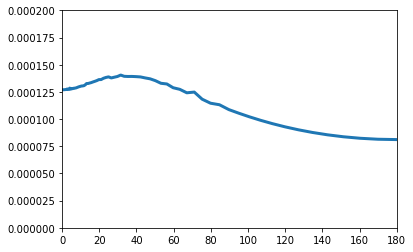

In [14]:
#print(Itot)
x = np.linspace(0., 180.)
plt.fill_between(x, Itot[0]-Itot[4],Itot[0]+Itot[3], color="grey", alpha=0.5)
plt.axhline(Itot[0], color="black")

#plt.plot(alpha*180/np.pi, (Jalphatide)*nfac, label="cusps (enc. + tide)", lw=3, color="red")
plt.plot(alpha*180/np.pi, (Jalphatot)*nfac, label="cusps (enc. + tide)", lw=3)
#plt.plot(alpha*180/np.pi, (Jalphatot+Jtothalo)*nfac, label="cusps (enc. + tide)", lw=3)
plt.ylim(0,2e-4)
plt.xlim(0,180)

# Spectrum

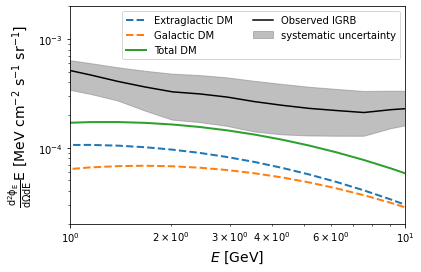

In [15]:
E = np.logspace(2, 6)
y = gammaray.igrb_dI_dloge(E)
#plt.fill_between(E, y[:,0]-y[:,2], y[:,0]+y[:,1], alpha=0.5, label="statistical uncertainty")

#plt.loglog(E, gammaray.igrb_fit_dI_dloge(E), color="C2", linestyle="dashed", label="fit from Ackermann et al. (2015)")

plt.ylabel(r"$\frac{\rm{d^2}\phi_E}{\rm{d}\Omega \rm{d} E} E$ [MeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]", fontsize=14)
plt.xlabel(r"$E$ [GeV]", fontsize=14)


plt.xlim(1, 10)
plt.ylim(2e-5,2e-3)



Iextragal = gammaray.extragalactic_dI_dloge(E/1e3, cuspdis, cusps)
Igal = gammaray.intragalactic_dI_dloge(E/1e3, sky_average(alpha, Jalphatot+Jtothalo, alphamin=20.*np.pi/180.))
plt.loglog(E/1e3, Iextragal, label="Extraglactic DM", linestyle="dashed", lw=2)
plt.loglog(E/1e3, Igal, label="Galactic DM", linestyle="dashed", lw=2)
plt.loglog(E/1e3, Igal+Iextragal, label="Total DM", lw=2)

plt.loglog(E/1e3, y[:,0], color="black", label="Observed IGRB")
plt.fill_between(E/1e3, y[:,0]-y[:,4], y[:,0]+y[:,3], alpha=0.5, label="systematic uncertainty", color="grey")
plt.legend(ncol=2, fontsize=10)

#plt.grid("on")

# MW luminosities for a distant observer

In [16]:
r200m = 0.340e6
sel = r[0] < r200m
nsel=1000
print("J0 %.3e" % np.sum(((J0s*mi)[:,sel]/mdm_per_samp/nsel).flatten()))
print("Jtide-only %.3e" % np.sum(((Jstide*mi)[:,sel]/mdm_per_samp/nsel).flatten()))
print("Jenc-only %.3e" % np.sum(((Js*mi)[:,sel]/mdm_per_samp/nsel).flatten()))
print("Jenc+tide %.3e" % np.sum(((Jstot*mi)[:,sel]/mdm_per_samp/nsel).flatten()))
print("Jsmooth contr. %.3e" % (mw.profile_contracted_nfw.integral_density_squared(rmin=1e-8, rmax=r200m*1e-6) / 1e18))
print("Jsmooth NFW %.3e" % (mw.profile_nfw.integral_density_squared(rmin=1e-8, rmax=r200m*1e-6) / 1e18))
print("Boost to NFW: %.1f" % (np.sum(((J0s*mi)[:,sel]/mdm_per_samp/nsel).flatten()) /(mw.profile_nfw.integral_density_squared(rmin=1e-8, rmax=r200m*1e-6) / 1e18)))
print("Boost to cNFW: %.1f" % (np.sum(((J0s*mi)[:,sel]/mdm_per_samp/nsel).flatten()) /(mw.profile_contracted_nfw.integral_density_squared(rmin=1e-8, rmax=r200m*1e-6) / 1e18)))

J0 2.273e+11
Jtide-only 1.848e+11
Jenc-only 1.971e+11
Jenc+tide 1.744e+11
Jsmooth contr. 5.105e+09
Jsmooth NFW 9.919e+08
Boost to NFW: 229.1
Boost to cNFW: 44.5
